## Planetary system simulation

In [264]:
import numpy as np
#constants:
G=6.67430E-11
#using other units i.e. AU should be considered

In [265]:
#class describing planet or asteroids
class SpaceObject:
    
    def __init__(self,name,mass,initialPosition,initialSpeedVector,radius,color='blue'):
        self.mass = mass
        self.speed = initialSpeedVector
        self.name = name
        self.position = initialPosition
        self.radius = radius
        self.color = color
        self.positionHistory = np.empty((0,3),float)
        print(self.positionHistory.shape)
        
    def acceleration(self,bodies):
        #https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
        acc = np.array([.0,.0,.0])
        for name,body in bodies:
            if not name==self.name:
                acc += body.mass*(body.position-self.position)/np.linalg.norm(body.position-self.position)**3
        return G*acc
    
    def setNewPosition(self,newPos):
        self.positionHistory = np.append(self.positionHistory,np.array([self.position]),axis=0)
        self.position = newPos

    def __str__(self):
        return "{};{:E};{:E};{:E};{:E};{:E};{:E};{:E}".format(self.name,
                          self.position[0], self.position[1], self.position[2],
                           self.speed[0], self.speed[1], self.speed[2],self.radius)
        

In [266]:
#collection of all objects in simulation as dictionary (key = name):

celestialBodies = {}
celestialBodies["Sun"] = SpaceObject(name="Sun",mass=1.98847E30,
                                     initialPosition=np.array([.0,.0,.0]),initialSpeedVector=[.0,.0,.0],
                                    radius=6.96340000E8, color="yellow")

#idk about current position of Earth, assumed that velocity vector is tangent to orbit sphere  
celestialBodies["Earth"] = SpaceObject(name="Earth",mass=5.972E24,
                                     initialPosition=np.array([.0,1.496E11,.0]),initialSpeedVector=[29.8E3,.0,.0],
                                    radius=6.371000E6, color="green")


(0, 3)
(0, 3)


In [267]:
#function that calculates center of mass for given list of planets / asteroids
def calculateModelCenterOfMass():
    pos = np.array([.0,.0,.0])
    massSum = 0
    for key,body in celestialBodies.items():
        pos += body.position*body.mass
        massSum += body.mass
    return pos/massSum

def printBodies(bodies):
    for name,body in bodies.items():
        print(body)


In [268]:
#showtime
#calculateModelCenterOfMass()
celestialBodies["Earth"].positionHistory.shape

(0, 3)

In [269]:
#single step of simulation
def calculateNewPositions(bodies,dt):
    positions = dict.fromkeys(bodies.keys())
    halfStepSpeeds = dict.fromkeys(bodies.keys())
    for name,body in bodies.items():
        #https://en.wikipedia.org/wiki/Leapfrog_integration probably can do better with Runge-Kutta method
        # conditon: dt<2/omega
        # 'kick-drift-form'
        
        halfStepSpeeds[name] = body.speed + body.acceleration(bodies.items())*dt/2
        positions[name] = body.position + halfStepSpeeds[name]*dt
     
    #apply new positons after all calculations for this timestep
    for name,body in bodies.items():
        body.setNewPosition(positions[name])
        #calculate speed considering new position
        body.speed = halfStepSpeeds[name] + body.acceleration(bodies.items())*dt/2
        

In [270]:
import datetime

      
start = datetime.datetime.now()
dt = 1*24*60*60
days = 256
end = start + datetime.timedelta(days = days)
simulationSteps = np.array([start + datetime.timedelta(days = day) for day in range(days)])

for day in simulationSteps:
    calculateNewPositions(celestialBodies,dt)
    

printBodies(celestialBodies)


Sun;2.401862E+06;6.105435E+05;0.000000E+00;1.180689E-01;-8.391497E-02;0.000000E+00;6.963400E+08
Earth;-1.423071E+11;-4.681661E+10;0.000000E+00;-9.270214E+03;2.827680E+04;0.000000E+00;6.371000E+06


<Figure size 432x288 with 0 Axes>

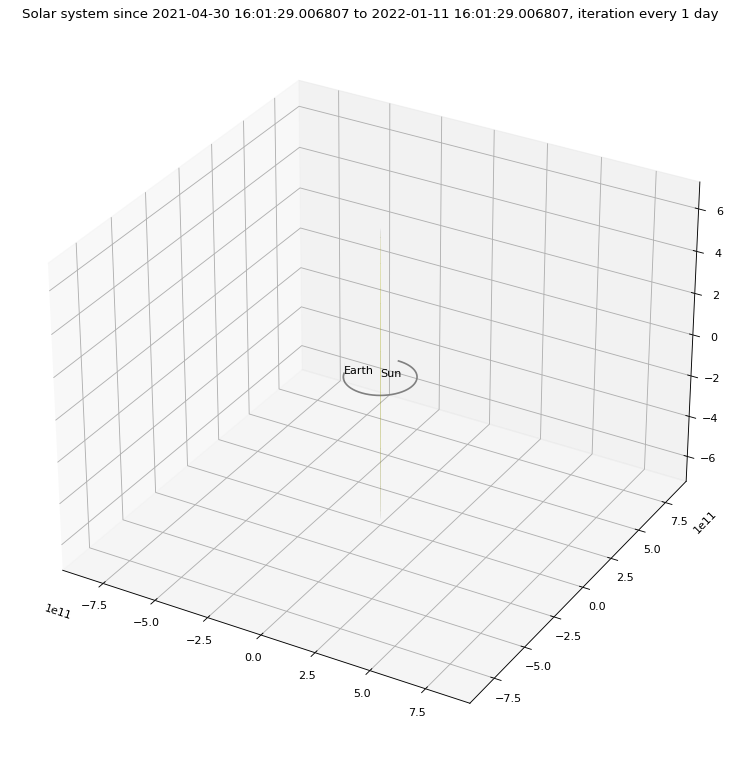

In [271]:
#3D animation makes me file like working in Pixar Studio oh yeaah
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from matplotlib.pyplot import figure

maxDim=9.09E11#solar system max radius with Neptun as furthest object (change to E12)



def plotCelestialBodies(bodies,title):
    fig = plt.figure()
    figure(figsize=(12, 12), dpi=80)
    ax = plt.axes(projection='3d')
    plt.title(title)
    plt.xlim([-maxDim, maxDim])
    plt.ylim([-maxDim, maxDim])
    for name,body in bodies.items():
        #somethings bugged for spherical plot and for large R it draws ugly line instead of spehere 
        #scatter is even worse because of calculation of marker size
        r = max(body.radius,5e7)
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x=np.cos(u)*np.sin(v)
        y=np.sin(u)*np.sin(v)
        z=np.cos(v)
        # shift and scale sphere
        x = r*x + body.position[0]
        y = r*y + body.position[1]
        z = r*z + body.position[2]
        ax.plot_surface(x, y, z, color=body.color, alpha=0.5)
        
        #plot path over time
        ax.plot(body.positionHistory[:,0],body.positionHistory[:,1],body.positionHistory[:,2],color="gray")
        ax.text(body.position[0], body.position[1], body.position[2], body.name)
        

        

    
plotCelestialBodies(celestialBodies,"Solar system since {} to {}, iteration every {} day".format(start,end,1))
